# Currency exchange example

Dataset used is the currency enchange with respect to USD dollars, from daily measurements from the last 2 years (2017-2018).

Currencies used: 
- Reference: USA
- Canadian dollar (CAD)
- Euro (EUR)
- Japanese yen (JPY)
- Great british pound (GBP)
- Swiss franc (CHF)
- Austrial dollar (AUD)
- Hong Kong dollar (HKD)
- New zealand dollar (NZD)
- South korean won (KRW)
- Mexican peso (MXN)

Please see our publication at https://doi.org/10.1109/ICASSP40776.2020.9054102 for a full description of this data set and the interpretations of our results.

In [1]:
import mogptk
import numpy as np
import pandas as pd

## Data loading

In [2]:
column_names = ['EUR/USD', 'CAD/USD', 'JPY/USD', 'GBP/USD', 'CHF/USD',
                'AUD/USD', 'HKD/USD','NZD/USD', 'KRW/USD','MXN/USD']

dataset = mogptk.DataSet()
for names in column_names:
    dataset.append(mogptk.LoadCSV('data/currency_exchange/final_dataset.csv',
                                    x_col='Date', y_col=names))

dataset.filter('2017-01-03', '2018-01-01')

In [3]:
# Preprocess by randomly removing points and detrending
for i, channel in enumerate(dataset):
    channel.transform(mogptk.TransformDetrend)
    channel.remove_randomly(pct=0.3)
    
    if i not in [0, 2, 5]:
        channel.remove_range('2017-11-17', None)
    
# simulate sensor failure
dataset[1].remove_range('2017-03-31', '2017-05-01')
dataset[2].remove_range('2017-12-28', None)
dataset[3].remove_range('2017-07-20', '2017-09-08')
dataset[4].remove_range(None, '2017-01-31')
dataset[5].remove_range('2017-12-28', None)
dataset[7].remove_range(None, '2017-01-31')

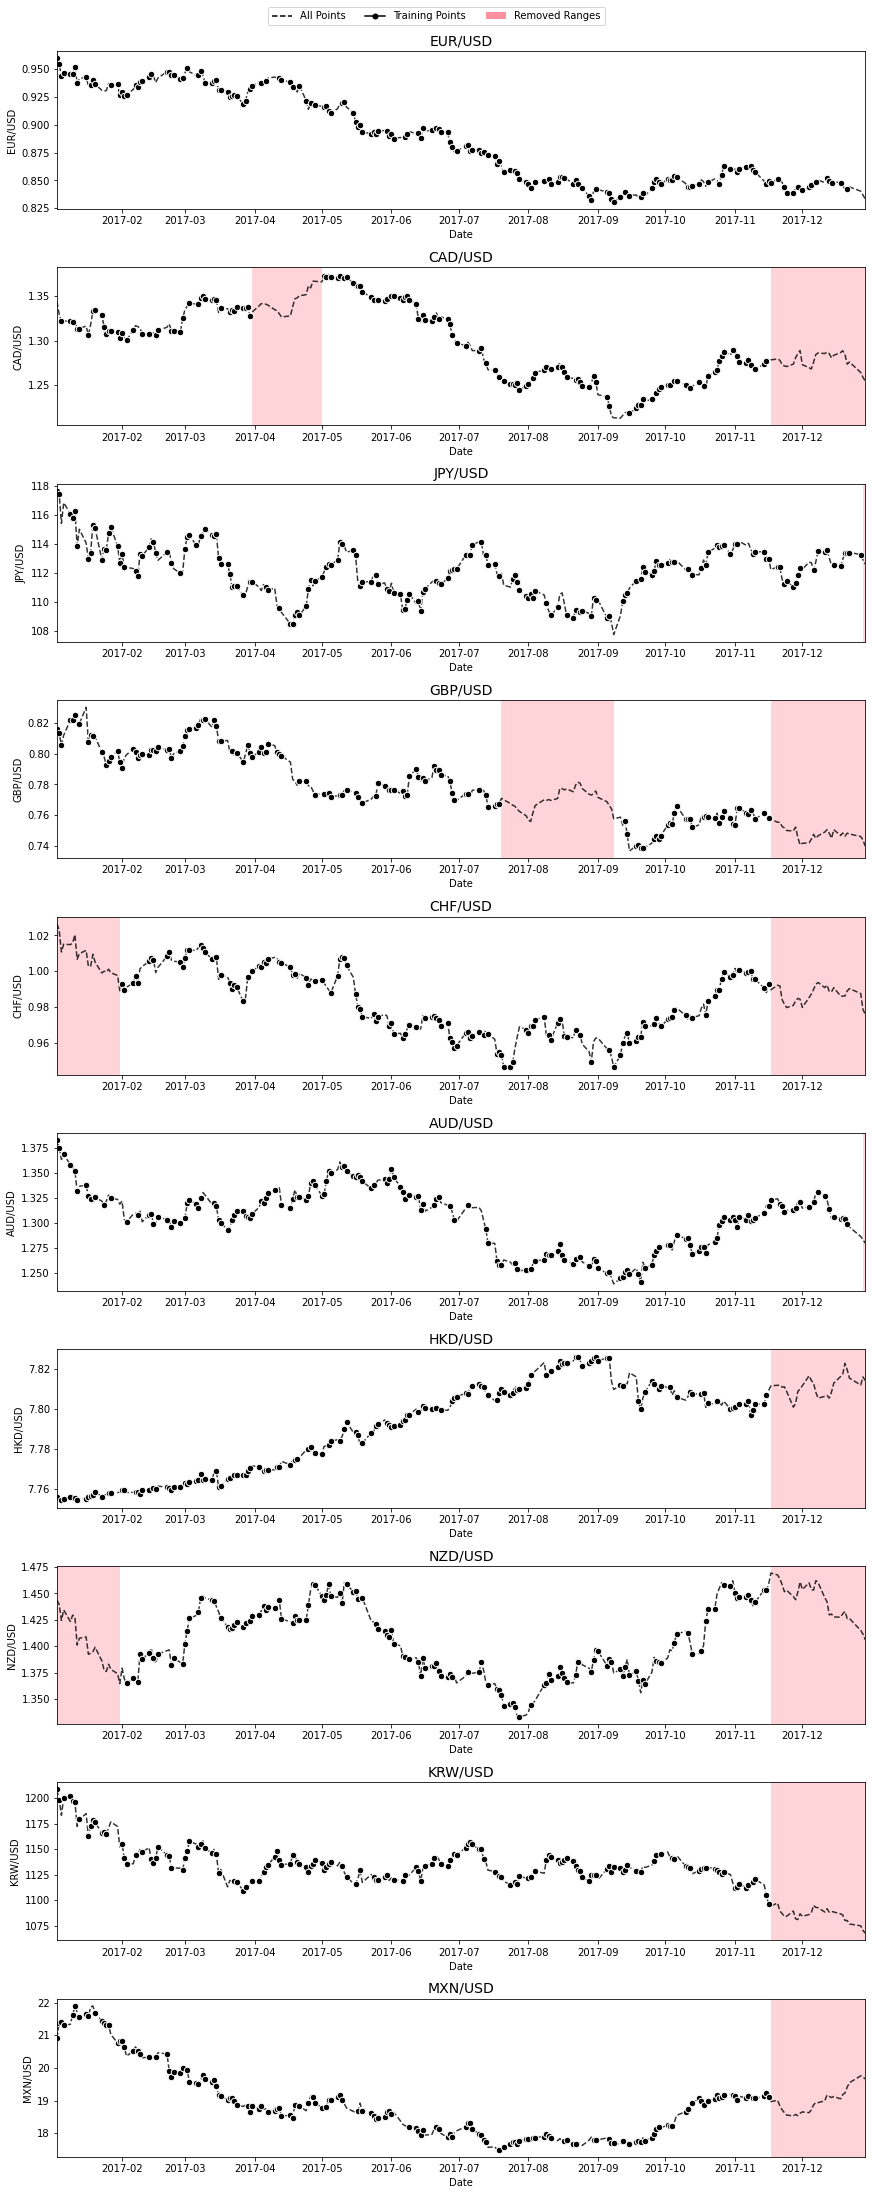

In [4]:
dataset.plot();

In [5]:
n_trials = 5
method = 'Adam'
lr = 0.1
iters = 500

## Multi-output spectral mixture kernel

In [6]:
mosm_models = []
mosm_mae = np.zeros((n_trials,10))
mosm_rmse = np.zeros((n_trials,10))
mosm_mape = np.zeros((n_trials,10))

# experiment trials
for n in range(n_trials):
    mosm_dataset = dataset.copy()
    for i, channel in enumerate(mosm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    mosm = mogptk.MOSM(mosm_dataset, Q=3)
    mosm.init_parameters('BNSE')
    mosm.train(method=method, lr=lr, iters=iters, verbose=True)
    mosm_models.append(mosm)
    print('=' * 50)
    
    error = mogptk.error(mosm, per_channel=True)[0]
    mosm_mae[n,:] = np.array([item['MAE'] for item in error])
    mosm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    mosm_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_rmse.mean(0), mosm_mape.mean(0),
             mosm_mae.std(0), mosm_rmse.std(0), mosm_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1086
‣ Parameters: 180
‣ Initial NLL: 0.536

Optimization finished in 9 minutes 23 seconds
‣ Function evaluations: 500
‣ Final NLL: -2.235

Trial 2 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1075
‣ Parameters: 180
‣ Initial NLL: 0.555

Optimization finished in 9 minutes 8 seconds
‣ Function evaluations: 500
‣ Final NLL: -2.273

Trial 3 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1083
‣ Parameters: 180
‣ Initial NLL: 0.498

Optimization finished in 9 minutes 13 seconds
‣ Function evaluations: 500
‣ Final NLL: -2.245

Trial 4 of 5

Starting optimization using Adam
‣ Model: MOSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1082
‣ Parameters: 180
‣ Initial NLL: -0.052

Optimization finished in 9 minutes 14 seconds
‣ Function evaluations: 500
‣ Final NLL: -2.220

Tri

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,0.065439,0.075698,7.584770,0.002214,0.001965,0.259044
1,0.051060,0.059840,3.991226,0.001847,0.002295,0.142489
2,0.774250,0.942313,0.691508,0.028025,0.034930,0.024620
3,0.038994,0.044953,5.118201,0.001936,0.001564,0.250155
4,0.014708,0.017116,1.499577,0.000957,0.000948,0.097024
5,0.024174,0.028675,1.865538,0.000415,0.000333,0.033138
6,0.035442,0.040623,0.454060,0.000611,0.000422,0.007823
7,0.011832,0.015397,0.834075,0.000974,0.001388,0.068811
8,35.008967,42.154099,3.153068,1.165056,1.591018,0.107390
9,1.062772,1.210384,5.742522,0.024680,0.027794,0.132825


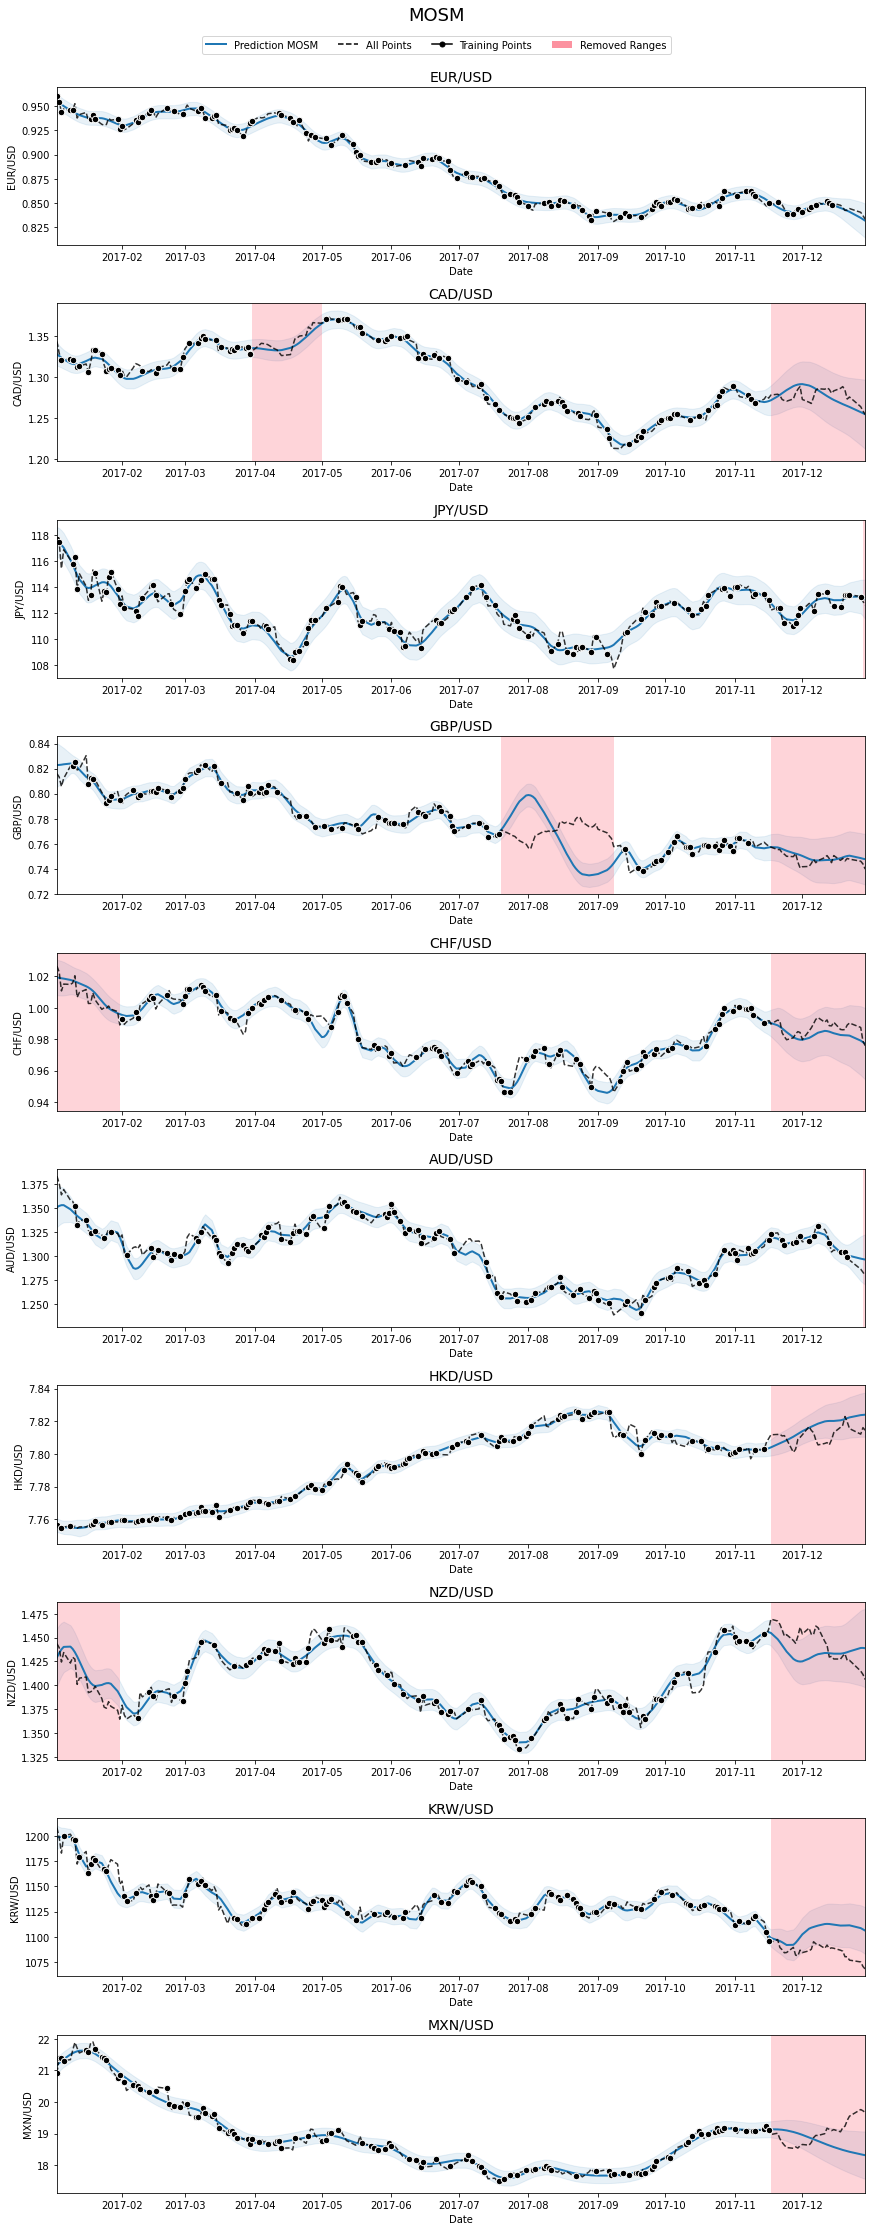

In [7]:
best_mosm = mosm_models[np.argmin(mosm_mape.mean(1))]
best_mosm.predict()
best_mosm.plot_prediction('MOSM');

## Cross spectral mixture kernel

In [8]:
csm_models = []
csm_mae = np.zeros((n_trials,10))
csm_rmse = np.zeros((n_trials,10))
csm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    csm_dataset = dataset.copy()
    for i, channel in enumerate(csm_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    csm = mogptk.CSM(csm_dataset, Q=3)
    csm.init_parameters('BNSE')    
    csm.train(method=method, lr=lr, iters=iters, verbose=True)
    csm_models.append(csm)
    print('=' * 50)
    
    error = mogptk.error(csm, per_channel=True)[0]
    csm_mae[n,:] = np.array([item['MAE'] for item in error])
    csm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    csm_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[csm_mae.mean(0), csm_rmse.mean(0), csm_mape.mean(0),
             csm_mae.std(0), csm_rmse.std(0), csm_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1099
‣ Parameters: 96
‣ Initial NLL: 0.340

Optimization finished in 8 minutes 26 seconds
‣ Function evaluations: 500
‣ Final NLL: -2.051

Trial 2 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1078
‣ Parameters: 96
‣ Initial NLL: 0.018

Optimization finished in 8 minutes 7 seconds
‣ Function evaluations: 500
‣ Final NLL: -2.091

Trial 3 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1074
‣ Parameters: 96
‣ Initial NLL: 0.213

Optimization finished in 8 minutes 10 seconds
‣ Function evaluations: 500
‣ Final NLL: -1.997

Trial 4 of 5

Starting optimization using Adam
‣ Model: CSM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1073
‣ Parameters: 96
‣ Initial NLL: 0.697

Optimization finished in 8 minutes 8 seconds
‣ Function evaluations: 500
‣ Final NLL: -1.990

Trial 5 of 5


,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,0.064903,0.075582,7.525861,0.001359,0.001131,0.163044
1,0.052848,0.061780,4.128063,0.001663,0.001843,0.128970
2,0.805758,1.002211,0.720462,0.127888,0.169932,0.114733
3,0.037641,0.045678,4.943809,0.003017,0.002866,0.382661
4,0.016421,0.019177,1.673957,0.000579,0.000769,0.059022
5,0.025042,0.029612,1.933196,0.000825,0.000922,0.064444
6,0.035297,0.040518,0.452214,0.000990,0.000576,0.012656
7,0.012058,0.015229,0.853222,0.000694,0.000681,0.050884
8,35.430606,41.992395,3.189097,0.957943,1.162240,0.086618
9,1.039809,1.197565,5.605828,0.029933,0.029658,0.155382


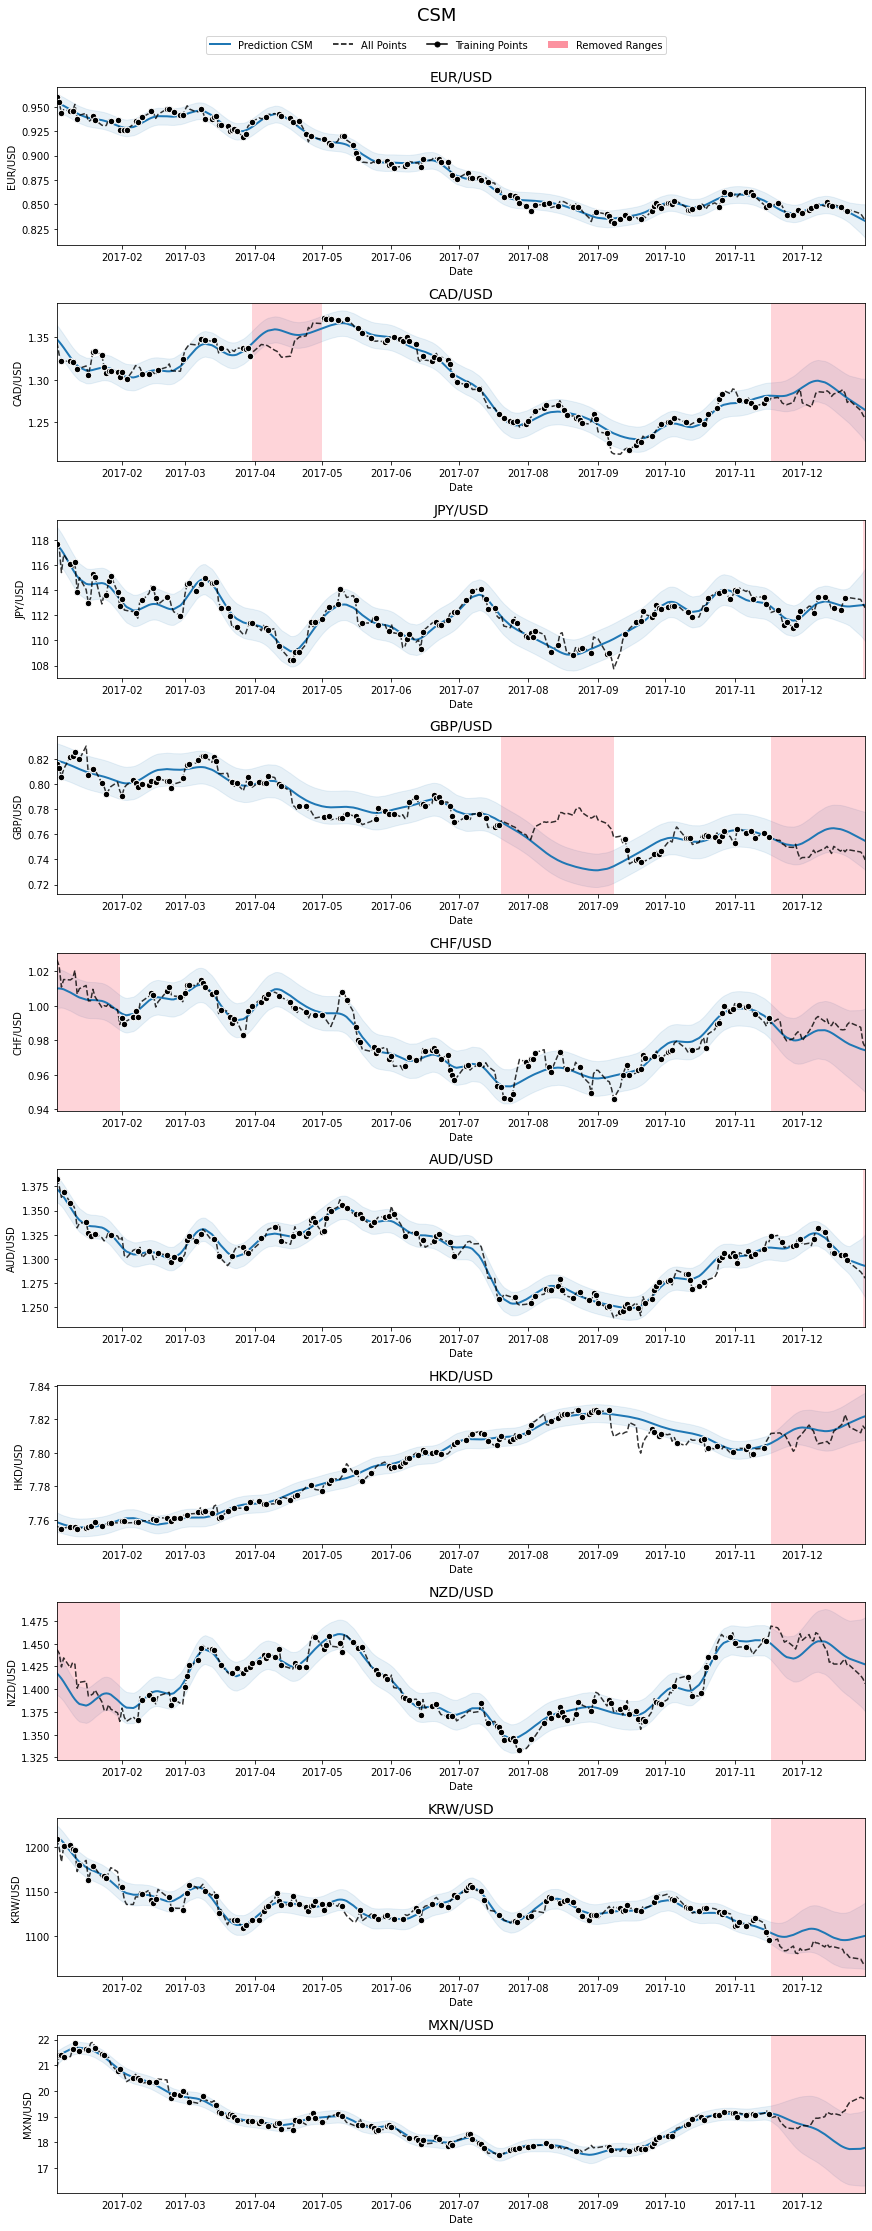

In [9]:
best_csm = csm_models[np.argmin(csm_mape.mean(1))]
best_csm.predict()
best_csm.plot_prediction('CSM');

## Linear model of coregionalization with spectral mixture kernels

In [10]:
smlmc_models = []
smlmc_mae = np.zeros((n_trials,10))
smlmc_rmse = np.zeros((n_trials,10))
smlmc_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    smlmc_dataset = dataset.copy()
    for i, channel in enumerate(smlmc_dataset):
        channel.remove_randomly(pct=0.3)
        
    print('\nTrial', n+1, 'of', n_trials)
    smlmc = mogptk.SM_LMC(smlmc_dataset, Q=3)
    smlmc.init_parameters('BNSE')
    smlmc.train(method=method, lr=lr, iters=iters, verbose=True)
    smlmc_models.append(smlmc)
    print('=' * 50)

    error = mogptk.error(smlmc, per_channel=True)[0]
    smlmc_mae[n,:] = np.array([item['MAE'] for item in error])
    smlmc_rmse[n,:] = np.array([item['RMSE'] for item in error])
    smlmc_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_rmse.mean(0), smlmc_mape.mean(0),
             smlmc_mae.std(0), smlmc_rmse.std(0), smlmc_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1091
‣ Parameters: 46
‣ Initial NLL: 8.560

Optimization finished in 4 minutes 11 seconds
‣ Function evaluations: 500
‣ Final NLL: -1.365

Trial 2 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1086
‣ Parameters: 46
‣ Initial NLL: 8.695

Optimization finished in 4 minutes 9 seconds
‣ Function evaluations: 500
‣ Final NLL: -1.490

Trial 3 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1083
‣ Parameters: 46
‣ Initial NLL: 8.666

Optimization finished in 4 minutes 11 seconds
‣ Function evaluations: 500
‣ Final NLL: -1.379

Trial 4 of 5

Starting optimization using Adam
‣ Model: SM-LMC
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1095
‣ Parameters: 46
‣ Initial NLL: 8.858

Optimization finished in 4 minutes 14 seconds
‣ Function evaluations: 500
‣ Final NLL: -1.537



,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,0.065156,0.075776,7.554947,0.002149,0.001788,0.255493
1,0.055445,0.064692,4.333233,0.002337,0.001810,0.173737
2,1.071361,1.333804,0.959580,0.025078,0.030578,0.022338
3,0.038753,0.044289,5.090009,0.000529,0.000467,0.070204
4,0.016781,0.019360,1.711692,0.000737,0.000663,0.076285
5,0.025747,0.030586,1.990123,0.000953,0.000800,0.072857
6,0.037385,0.041975,0.478927,0.001021,0.000614,0.013111
7,0.015131,0.018444,1.068640,0.001493,0.001470,0.105847
8,42.405318,63.641906,3.833803,5.469943,11.764076,0.501622
9,1.034770,1.172821,5.573488,0.006707,0.011344,0.034791


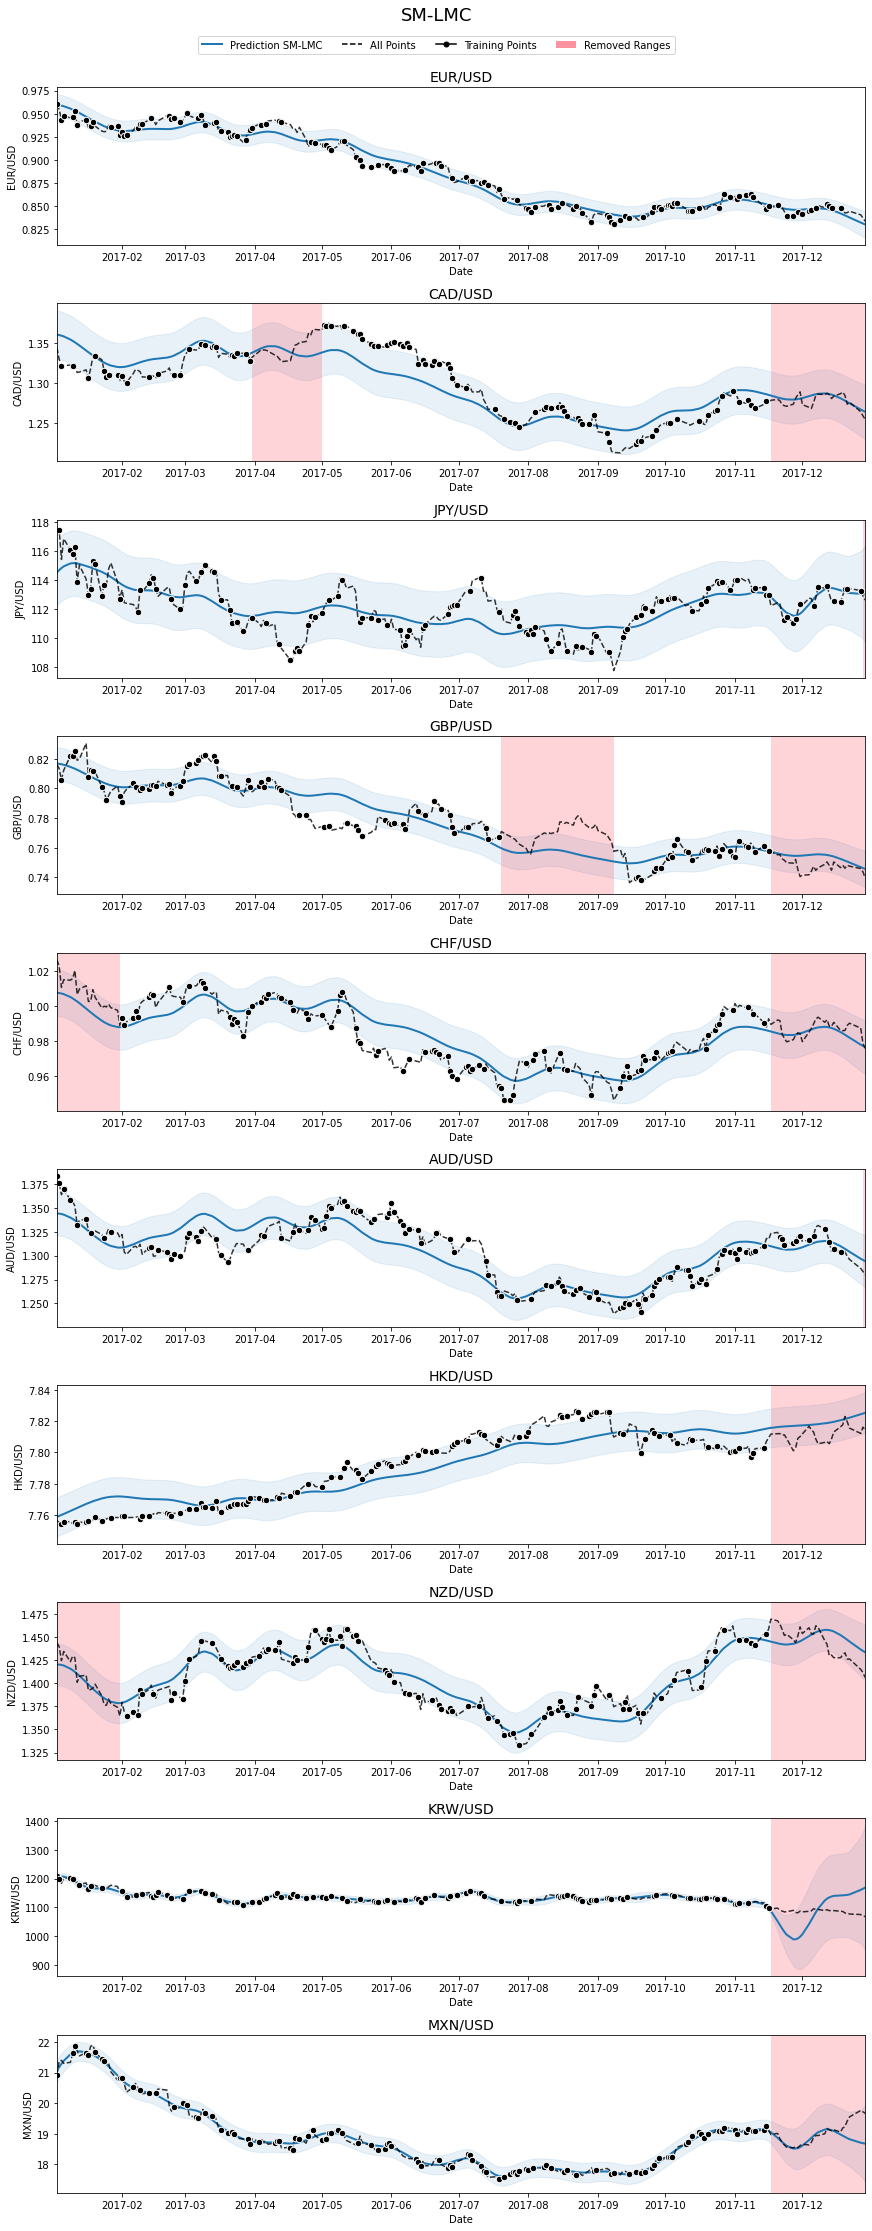

In [11]:
best_smlmc = smlmc_models[np.argmin(smlmc_mape.mean(1))]
best_smlmc.predict()
best_smlmc.plot_prediction('SM-LMC');

## Independent spectral mixture kernels

In [12]:
sm_models = []
sm_mae = np.zeros((n_trials,10))
sm_rmse = np.zeros((n_trials,10))
sm_mape = np.zeros((n_trials,10))

for n in range(n_trials):
    sm_dataset = dataset.copy()
    for i, channel in enumerate(sm_dataset):
        channel.remove_randomly(pct=0.3)
    
    print('\nTrial', n+1, 'of', n_trials)
    sm = mogptk.SM(sm_dataset, Q=3)
    sm.init_parameters('BNSE')
    sm.train(method=method, lr=lr, iters=iters, verbose=True)
    sm_models.append(sm)
    print('=' * 50)
        
    error = mogptk.error(sm, per_channel=True)[0]
    sm_mae[n,:] = np.array([item['MAE'] for item in error])
    sm_rmse[n,:] = np.array([item['RMSE'] for item in error])
    sm_mape[n,:] = np.array([item['MAPE'] for item in error])
    
pd.DataFrame(np.c_[sm_mae.mean(0), sm_rmse.mean(0), sm_mape.mean(0),
             sm_mae.std(0), sm_rmse.std(0), sm_mape.std(0)],
             columns=['MAE', 'RMSE', 'MAPE', 'MAE std', 'RMSE std', 'MAPE std'])


Trial 1 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1096
‣ Parameters: 100
‣ Initial NLL: 1.486

Optimization finished in 2 minutes 53 seconds
‣ Function evaluations: 500
‣ Final NLL: -0.608

Trial 2 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1084
‣ Parameters: 100
‣ Initial NLL: 1.453

Optimization finished in 2 minutes 48 seconds
‣ Function evaluations: 500
‣ Final NLL: -0.624

Trial 3 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1088
‣ Parameters: 100
‣ Initial NLL: 1.466

Optimization finished in 2 minutes 48 seconds
‣ Function evaluations: 500
‣ Final NLL: -0.599

Trial 4 of 5

Starting optimization using Adam
‣ Model: SM
‣ Channels: 10
‣ Mixtures: 3
‣ Training points: 1105
‣ Parameters: 100
‣ Initial NLL: 1.516

Optimization finished in 2 minutes 56 seconds
‣ Function evaluations: 500
‣ Final NLL: -0.603

Trial 5 of 

,MAE,RMSE,MAPE,MAE std,RMSE std,MAPE std
0,0.063260,0.074096,7.349226,0.001932,0.001718,0.230435
1,0.049870,0.057348,3.907563,0.000768,0.000531,0.059107
2,0.757477,0.908970,0.677269,0.060159,0.065041,0.053806
3,0.039374,0.043965,5.168675,0.001275,0.000953,0.168537
4,0.015202,0.018131,1.556066,0.000719,0.000819,0.074436
5,0.025794,0.031323,2.004289,0.001163,0.001389,0.092849
6,0.034392,0.039394,0.440521,0.000809,0.000648,0.010363
7,0.017588,0.022384,1.235278,0.000656,0.000589,0.045532
8,35.525748,42.217690,3.197974,0.686933,0.409508,0.060840
9,1.046169,1.202062,5.647385,0.016452,0.011311,0.092307


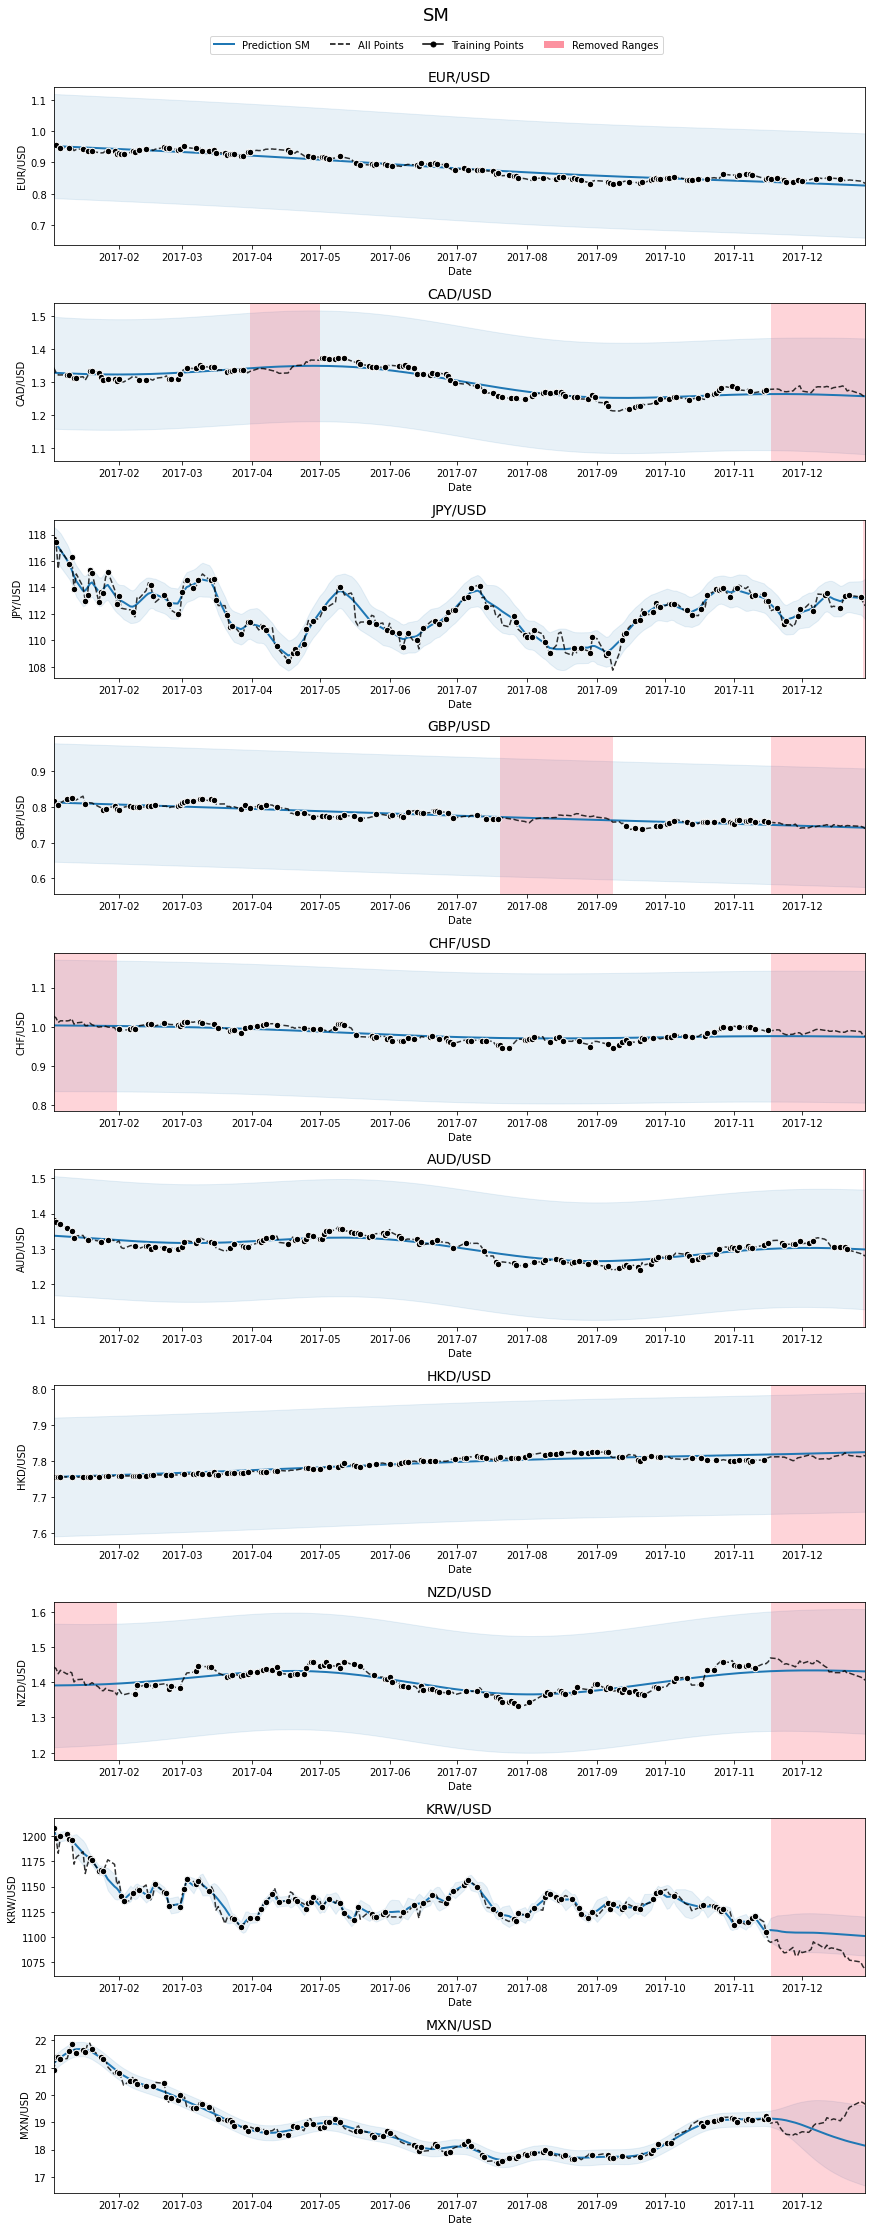

In [13]:
best_sm = sm_models[np.argmin(sm_mape.mean(1))]
best_sm.predict()
best_sm.plot_prediction('SM');

## Results

In [14]:
print('MAPE errors per model')
print('MOSM:    %g ± %g' % (mosm_mape.mean(1).mean(), mosm_mape.mean(1).std()))
print('CSM:     %g ± %g' % (csm_mape.mean(1).mean(), csm_mape.mean(1).std()))
print('SM-LMC:  %g ± %g' % (smlmc_mape.mean(1).mean(), smlmc_mape.mean(1).std()))
print('SM:      %g ± %g' % (sm_mape.mean(1).mean(), sm_mape.mean(1).std()))

MAPE errors per model
MOSM:    3.09345 ± 0.0467448
CSM:     3.10257 ± 0.0410683
SM-LMC:  3.25944 ± 0.0592989
SM:      3.11842 ± 0.037197
